# Ejercicio 2

* La columna arr_port es el código IATA del aeropuerto te llegada
* Para obtener el número total de pasajeros de un aeropuerto hay que sumar la columna pax agrupando por arr_port. Nota que hay pax negativo, correspondiente a las cancelaciones. Al sumar los negativos restaran las cancelaciones.
* Imprimir el top 10 de aeropuertos con más llegadas a la salida estándar. Incluir el número de pasajeros
* Bonus: Obtener el nombre de la ciudad a la que corresponde el aeropuerto programáticamente. Usar GeoBases

In [1]:
import bz2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neobase import NeoBase

In [2]:
bookings_path = "/home/dsc/data/challenge/bookings.csv.bz2"
searches_path = "/home/dsc/data/challenge/searches.csv.bz2"

### Enfoque 1

Cargamos sólo los campos necesarios de forma que la memoria usada sea menos

In [3]:
df = pd.read_csv(
    bookings_path, 
    compression = "bz2", 
    sep = "^", 
    memory_map = True, 
    error_bad_lines = False,
    usecols=["arr_port","pax"]
)

In [4]:
# La tabla es bastante grande, unos 640 mb (80000080 B) por columna 
df.memory_usage()

Index            128
arr_port    80000080
pax         80000080
dtype: int64

In [5]:
# Primer intento, sin comprobar nada
quick_result = df.groupby(by="arr_port").sum().sort_values(by="pax", ascending=False)[0:10]
quick_result

,pax
arr_port,
LHR,88809.0
MCO,70930.0
LAX,70530.0
LAS,69630.0
JFK,66270.0
CDG,64490.0
BKK,59460.0
MIA,58150.0
SFO,58000.0


In [6]:
# hay códigos con más de 3 caracteres y con menos de 3 que estan mal (codigo IATA)
df["arr_port"].unique()

array(['LHR     ', 'CLT     ', 'SVO     ', ..., 'VEL     ', 'SLM     ',
       'SG      '], dtype=object)

In [7]:
# todos tienen padding
df.groupby(by=df["arr_port"].str.len()).count()

,arr_port,pax
arr_port,,
8,10000010,10000009


In [8]:
# arreglamos los códigos IATA para evitar los espacios
df["arr_port"] = df["arr_port"].str.upper()
df["arr_port"] = df["arr_port"].str.strip()
df["arr_port"].unique()

array(['LHR', 'CLT', 'SVO', ..., 'VEL', 'SLM', 'SG'], dtype=object)

In [10]:
df.groupby(by=df["arr_port"].str.len()).count()

,arr_port,pax
arr_port,,
2,1,0
3,10000009,10000009


In [11]:
# eliminamos el aeropuerto con 2 letras
df.reset_index()
df = df[df["arr_port"].str.len() == 3]

In [12]:
df.groupby(by=df["arr_port"].str.len()).count()

,arr_port,pax
arr_port,,
3,10000009,10000009


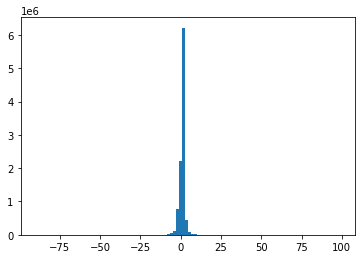

In [13]:
# Comprobamos la distribución de los datos
plt.hist(df["pax"], bins = 100);

In [14]:
# Comprobamos si aun quedan na
df.isna().sum()

arr_port    0
pax         0
dtype: int64

In [15]:
# Cambiamos los tiposde las columnas y sumamos
df = df.astype({"arr_port": str, "pax": int})
result = df.groupby(by="arr_port").sum().sort_values(by="pax", ascending=False)[0:10]
result

,pax
arr_port,
LHR,88809
MCO,70930
LAX,70530
LAS,69630
JFK,66270
CDG,64490
BKK,59460
MIA,58150
SFO,58000


In [16]:
#finalmente imprimir a salida estándar
count = 1
for index, row in result.iterrows():
    print(f"({count}) Aeropuerto: {index} --> Pasajeros: {row['pax']}")
    count += 1

(1) Aeropuerto: LHR --> Pasajeros: 88809
(2) Aeropuerto: MCO --> Pasajeros: 70930
(3) Aeropuerto: LAX --> Pasajeros: 70530
(4) Aeropuerto: LAS --> Pasajeros: 69630
(5) Aeropuerto: JFK --> Pasajeros: 66270
(6) Aeropuerto: CDG --> Pasajeros: 64490
(7) Aeropuerto: BKK --> Pasajeros: 59460
(8) Aeropuerto: MIA --> Pasajeros: 58150
(9) Aeropuerto: SFO --> Pasajeros: 58000
(10) Aeropuerto: DXB --> Pasajeros: 55590


### Enfoque 2
cargar el dataset por trozos

In [17]:
df_acum = pd.DataFrame()
chunksize = 1000000 #10⁶

reader = pd.read_csv(bookings_path, 
                     compression = "bz2", 
                     sep = "^", 
                     memory_map = True, 
                     error_bad_lines = False,
                     usecols=["arr_port","pax"],
                     chunksize=chunksize)    


for chunk in reader:      
    curr = chunk.groupby(by="arr_port").sum()
    if df_acum.empty:
        df_acum = curr
    else:
        df_acum = pd.concat([df_acum, curr])

In [18]:
result = df_acum.groupby(by="arr_port").sum().sort_values(by="pax", ascending=False)[0:10]
result = result.astype({"pax": int})
result

,pax
arr_port,
LHR,88809
MCO,70930
LAX,70530
LAS,69630
JFK,66270
CDG,64490
BKK,59460
MIA,58150
SFO,58000


In [37]:
b = NeoBase()
result.index = result.index.map(lambda x: x.strip())
result["City"] = result.index.map(lambda x: b.get(x, "city_name_list")[0])

In [38]:
result

,pax,City
arr_port,,
LHR,88809,London
MCO,70930,Orlando
LAX,70530,Los Angeles
LAS,69630,Las Vegas
JFK,66270,New York City
CDG,64490,Paris
BKK,59460,Bangkok
MIA,58150,Miami
SFO,58000,San Francisco


In [39]:
#finalmente imprimir a salida estándar
count = 1
for index, row in result.iterrows():
    print(f"({count}) Aeropuerto: {index}; Ciudad: {row['City']} --> Pasajeros: {row['pax']}")
    count += 1

(1) Aeropuerto: LHR; Ciudad: London --> Pasajeros: 88809
(2) Aeropuerto: MCO; Ciudad: Orlando --> Pasajeros: 70930
(3) Aeropuerto: LAX; Ciudad: Los Angeles --> Pasajeros: 70530
(4) Aeropuerto: LAS; Ciudad: Las Vegas --> Pasajeros: 69630
(5) Aeropuerto: JFK; Ciudad: New York City --> Pasajeros: 66270
(6) Aeropuerto: CDG; Ciudad: Paris --> Pasajeros: 64490
(7) Aeropuerto: BKK; Ciudad: Bangkok --> Pasajeros: 59460
(8) Aeropuerto: MIA; Ciudad: Miami --> Pasajeros: 58150
(9) Aeropuerto: SFO; Ciudad: San Francisco --> Pasajeros: 58000
(10) Aeropuerto: DXB; Ciudad: Dubai --> Pasajeros: 55590


In [40]:
count = 1
with open("resultado.csv", "w") as f:
    f.write("Rank,Aeropuerto,Ciudad,Pasajeros\n")
    for index, row in result.iterrows():
        f.write(f"{count},{index},{row['City']}{row['pax']}\n")        
        count += 1